Dataset shape: (27819, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

     

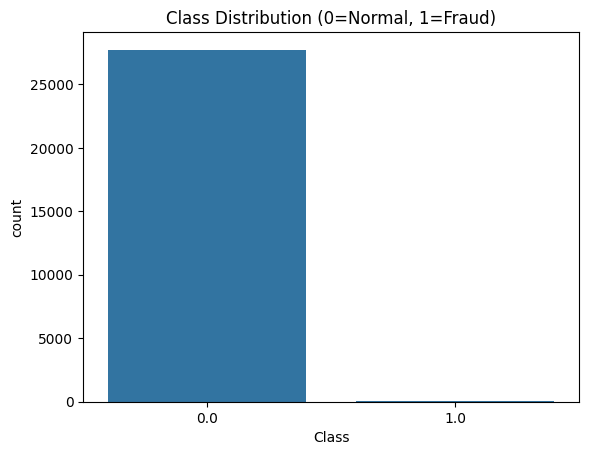

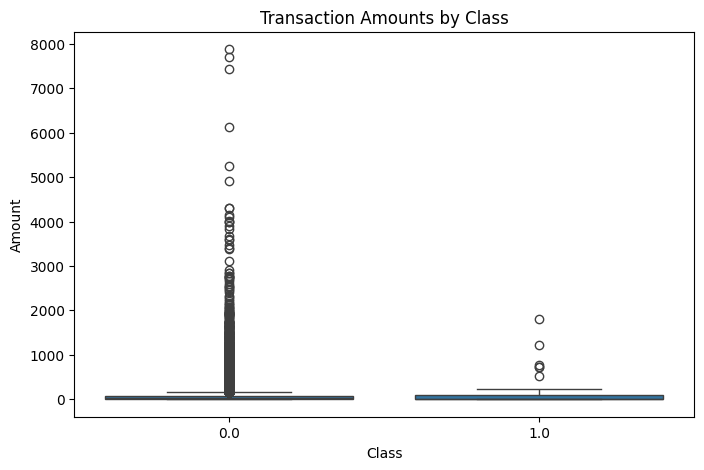

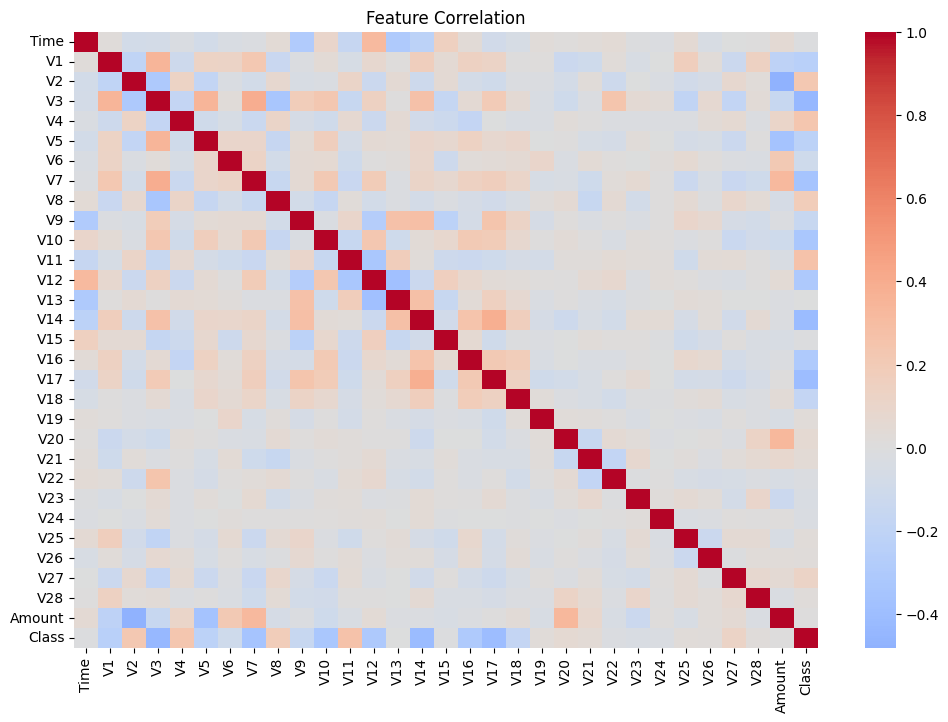

In [3]:

#  Install & Import Libraries

!pip install imbalanced-learn xgboost shap --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


#  Load Dataset

df = pd.read_csv("creditcard.csv")   # path to dataset
print("Dataset shape:", df.shape)
print(df.head())
print(df['Class'].value_counts())


#  Exploratory Data Analysis


# Class distribution
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0=Normal, 1=Fraud)")
plt.show()

# Transaction amount distribution
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Transaction Amounts by Class")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation")
plt.show()


#  Data Preprocessing

scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

X = df.drop('Class', axis=1)
y = df['Class']


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:10:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

         0.0     0.9995    0.9995    0.9995      5545
         1.0     0.8421    0.8421    0.8421        19

    accuracy                         0.9989      5564
   macro avg     0.9208    0.9208    0.9208      5564
weighted avg     0.9989    0.9989    0.9989      5564

✅ Model saved at data/processed/xgb_fraud_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

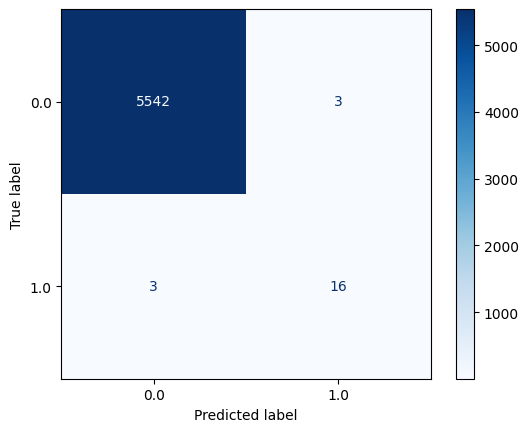

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import os


# Handle Missing Values
# Drop rows with missing values in X or y
df_cleaned = df.dropna(subset=X.columns.tolist() + [y.name])
X_cleaned = df_cleaned.drop('Class', axis=1)
y_cleaned = df_cleaned['Class']


# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned
)

# Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


# Train XGBoost
ratio = (y_train_res==0).sum() / (y_train_res==1).sum()

xgb_model = XGBClassifier(
    scale_pos_weight=ratio,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_res, y_train_res)

# Evaluate
y_pred = xgb_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")


# Save Model

os.makedirs("data/processed", exist_ok=True)
joblib.dump(xgb_model, "data/processed/xgb_fraud_model.pkl")
print("✅ Model saved at data/processed/xgb_fraud_model.pkl")


# Download Model from Colab

from google.colab import files
files.download("data/processed/xgb_fraud_model.pkl")